In [1]:
# core
import sys
import time

# custom
sys.path.append('../code/poloniex')
sys.path.append('../code')
import polo_eda as pe
import calc_TA_sigs as cts
import data_processing as dp

# installed
import pandas as pd
import numpy as np

# plotting
import plotly
plotly.offline.init_notebook_mode()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout, Candlestick
from plotly.tools import FigureFactory as FF
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pe.read_trade_hist('BTC_LTC')

In [3]:
# resamples to the hour
rs_full = dp.resample_ohlc(df, resamp='H')

In [4]:
# make time features: day of week, month, hour
rs_full['weekday'] = rs_full.index.dayofweek
rs_full['month'] = rs_full.index.month
rs_full['hour'] = rs_full.index.hour

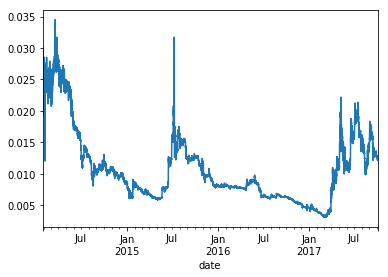

In [5]:
f = rs_full.close[240:].plot()

In [6]:
# 24-hour moving average of typical price
mva_tp_24 = rs_full['typical_price'].rolling(24).mean().bfill()
mva_tp_48 = rs_full['typical_price'].rolling(48).mean().bfill()

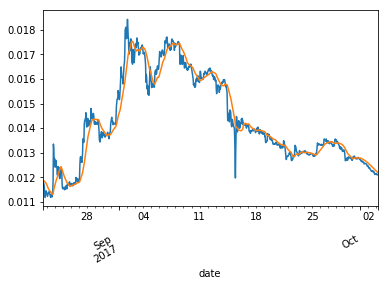

In [7]:
fig = plt.figure()
f = rs_full['typical_price'].iloc[-1000:].plot()
f = mva_tp_24.iloc[-1000:].plot()
fig.autofmt_xdate()

In [8]:
# calculate slopes/derivatives of 15-min mva
mva_tp_24_diff = mva_tp_24.diff().bfill()
mva_tp_24_diff2 = mva_tp_24_diff.diff().bfill()
mva_tp_48_diff = mva_tp_48.diff().bfill()
mva_tp_48_diff2 = mva_tp_48_diff.diff().bfill()

In [9]:
mva_tp_24.shape

(32496,)

In [10]:
rs_full.shape

(32496, 10)

In [11]:
mva_tp_24_diff.shape

(32496,)

In [12]:
rs_full['mva_tp_24'] = mva_tp_24
rs_full['mva_tp_24_diff'] = mva_tp_24_diff
rs_full['mva_tp_24_diff2'] = mva_tp_24_diff2
rs_full['mva_tp_48'] = mva_tp_48
rs_full['mva_tp_48_diff'] = mva_tp_48_diff
rs_full['mva_tp_48_diff2'] = mva_tp_48_diff2

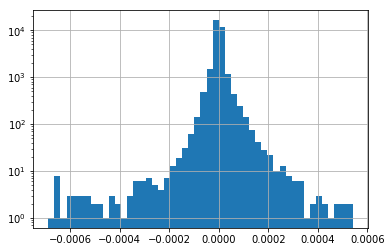

In [13]:
# whoa, some major outliers in the slopes...
f = mva_tp_24_diff.hist(bins=50)
plt.yscale('log')

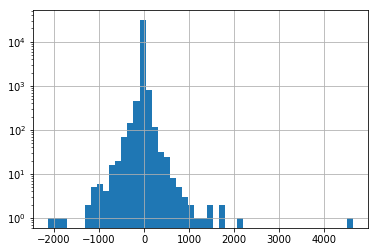

In [14]:
f = rs_full['direction_volume'].hist(bins=50)
plt.yscale('log')

# calculate the difference in price 24 hours from now, does it correlate to the current mva slope or direction_volume?

In [15]:
rs_full['24h_price_diff'] = rs_full['typical_price'].copy()

In [179]:
rs_full['24h_price_diff'] = np.hstack((np.repeat(rs_full['24h_price_diff'].iloc[24], 24), rs_full['typical_price'].iloc[24:].values - rs_full['typical_price'].iloc[:-24].values))

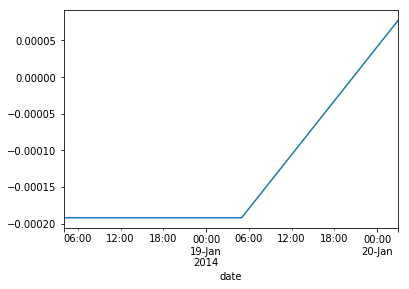

In [180]:
rs_full['24h_price_diff'].iloc[:48].plot()

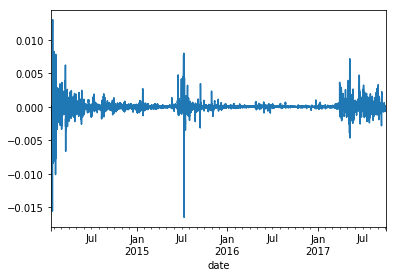

In [18]:
rs_full['24h_price_diff'].iloc[48:].plot()

In [32]:
rs_clip = rs_full.iloc[48:].copy()

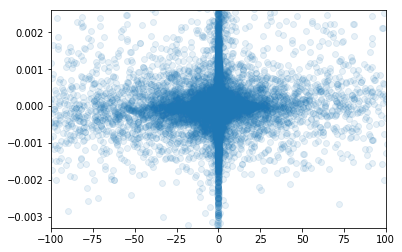

In [85]:
# weak correlation, but seems to be there
hist = 14  # number of points that the mva is behind the price diff
f = plt.scatter(rs_clip['direction_volume'].iloc[24-hist:-hist].values, rs_clip['24h_price_diff'].iloc[24:].values, alpha=0.1)
ylim = plt.ylim([rs_clip['24h_price_diff'].min()*0.2, rs_clip['24h_price_diff'].max()*0.2])
xlim = plt.xlim([-100, 100])

# bottom line: if the mva slope is positive, 12 hours later, the price will probably be up, proportional to the slope, and vice-versa

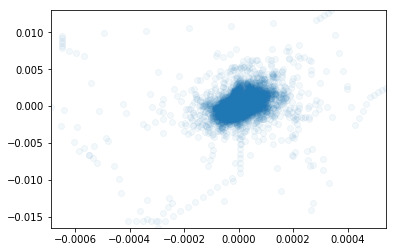

In [86]:
hist = 14  # number of points that the mva is behind the price diff
f = plt.scatter(rs_clip['mva_tp_24_diff'].iloc[24 - hist:-hist].values, rs_clip['24h_price_diff'].iloc[24:].values, alpha=0.05)
ylim = plt.ylim([rs_clip['24h_price_diff'].min(), rs_clip['24h_price_diff'].max()])
xlim = plt.xlim([rs_clip['mva_tp_24_diff'].min(), rs_clip['mva_tp_24_diff'].max()])

# the second derivative is not as informative

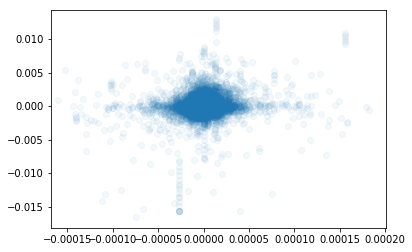

In [81]:
hist = 12  # number of points that the mva is behind the price diff
xcol = 'mva_tp_24_diff2'
f = plt.scatter(rs_clip[xcol].iloc[24-hist:-hist].values, rs_clip['24h_price_diff'].iloc[24:].values, alpha=0.05)
ylim = plt.ylim([rs_clip['24h_price_diff'].min()*1.1, rs_clip['24h_price_diff'].max()*1.1])
xlim = plt.xlim([rs_clip[xcol].min()*0.5, rs_clip[xcol].max()*0.5])

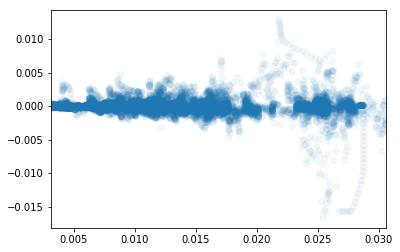

In [88]:
xcol = 'mva_tp_48'
hist = 12
f = plt.scatter(rs_clip[xcol].iloc[24-hist:-hist].values, rs_clip['24h_price_diff'].iloc[24:].values, alpha=0.05)
ylim = plt.ylim([rs_clip['24h_price_diff'].min()*1.1, rs_clip['24h_price_diff'].max()*1.1])
xlim = plt.xlim([rs_clip[xcol].min(), rs_clip[xcol].max()])

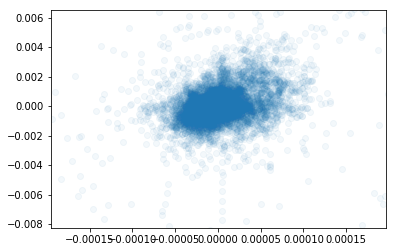

In [82]:
hist = 12
xcol = 'mva_tp_48_diff'
f = plt.scatter(rs_clip[xcol].iloc[24-hist:-hist].values, rs_clip['24h_price_diff'].iloc[24:].values, alpha=0.05)
ylim = plt.ylim([rs_clip['24h_price_diff'].min()*0.5, rs_clip['24h_price_diff'].max()*0.5])
xlim = plt.xlim([rs_clip[xcol].min()*0.5, rs_clip[xcol].max()*0.5])

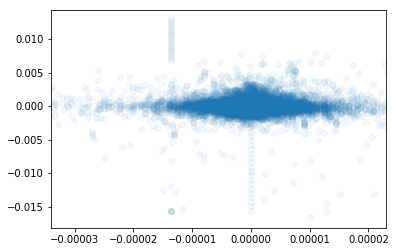

In [37]:
xcol = 'mva_tp_48_diff2'
f = plt.scatter(rs_clip[xcol].iloc[:-24].values, rs_clip['24h_price_diff'].iloc[24:].values, alpha=0.05)
ylim = plt.ylim([rs_clip['24h_price_diff'].min()*1.1, rs_clip['24h_price_diff'].max()*1.1])
xlim = plt.xlim([rs_clip[xcol].min()*0.2, rs_clip[xcol].max()*0.1])

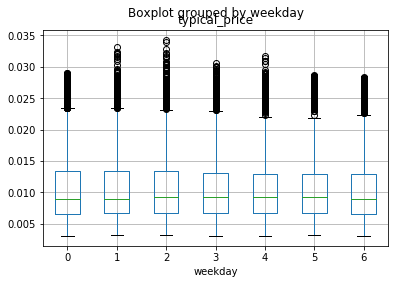

In [29]:
# Monday=0, Sunday=6
rs_clip.boxplot(column='typical_price', by='weekday')

(-0.0001, 0.0001)

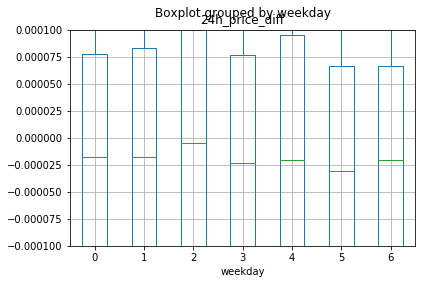

In [40]:
rs_clip.boxplot(column='24h_price_diff', by='weekday')
plt.ylim([-0.0001, 0.0001])

(-0.001, 0.001)

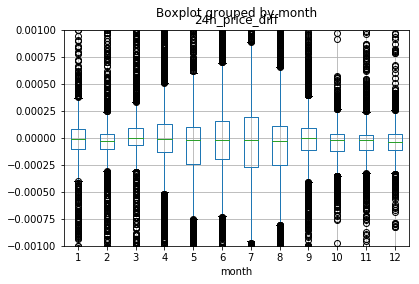

In [42]:
rs_clip.boxplot(column='24h_price_diff', by='month')
plt.ylim([-0.001, 0.001])

(-0.0001, 0.0001)

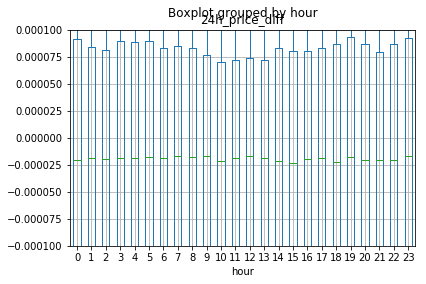

In [44]:
rs_clip.boxplot(column='24h_price_diff', by='hour')
plt.ylim([-0.0001, 0.0001])

# try fitting a linear model to the different historic times

In [89]:
import statsmodels.api as sm

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [202]:
hist = 24
X = sm.add_constant(rs_clip['mva_tp_24_diff'].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1179.
Date:                Tue, 03 Oct 2017   Prob (F-statistic):          1.23e-253
Time:                        00:39:48   Log-Likelihood:             1.7878e+05
No. Observations:               31424   AIC:                        -3.576e+05
Df Residuals:                   31422   BIC:                        -3.575e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.518e-05   4.62e-06     -3.287      0.001   -2.42e-05   -6.13e-06
x1            -4.5646      0.133    -34.333      0.000      -4.825      -4.304
==============================================================================
Omnibus:                    27339.422   Durbin-Watson:                   0.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11361080.757
Skew:                          -3.251   Prob(JB):                         0.00
Kurtosis:                      95.923   Cond. No.                     2.88e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [205]:
fit.rsquared

0.036158004758982121

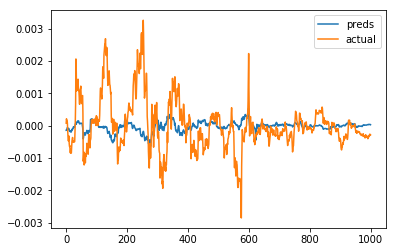

In [100]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

In [101]:
hist = 14
X = sm.add_constant(rs_clip['mva_tp_24_diff'].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     2883.
Date:                Mon, 02 Oct 2017   Prob (F-statistic):               0.00
Time:                        22:32:43   Log-Likelihood:             1.7958e+05
No. Observations:               31424   AIC:                        -3.592e+05
Df Residuals:                   31422   BIC:                        -3.591e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.942e-06    4.5e-06     -1.987      0.047   -1.78e-05    -1.2e-07
x1             6.9582      0.130     53.691      0.000       6.704       7.212
==============================================================================
Omnibus:                    20300.010   Durbin-Watson:                   0.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14838756.331
Skew:                          -1.744   Prob(JB):                         0.00
Kurtosis:                     109.400   Cond. No.                     2.88e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

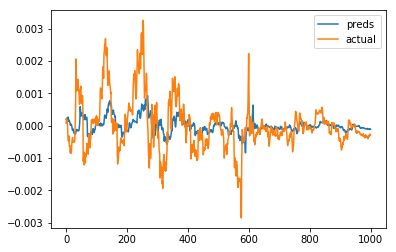

In [102]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

In [103]:
hist = 12
X = sm.add_constant(rs_clip['mva_tp_24_diff'].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     5255.
Date:                Mon, 02 Oct 2017   Prob (F-statistic):               0.00
Time:                        22:33:14   Log-Likelihood:             1.8063e+05
No. Observations:               31424   AIC:                        -3.613e+05
Df Residuals:                   31422   BIC:                        -3.612e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -7.81e-06   4.35e-06     -1.794      0.073   -1.63e-05    7.22e-07
x1             9.0857      0.125     72.492      0.000       8.840       9.331
==============================================================================
Omnibus:                    17392.291   Durbin-Watson:                   0.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14191806.058
Skew:                          -1.234   Prob(JB):                         0.00
Kurtosis:                     107.081   Cond. No.                     2.88e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

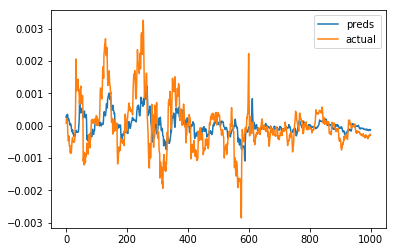

In [106]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

In [108]:
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff', 'mva_tp_48_diff']].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     2848.
Date:                Mon, 02 Oct 2017   Prob (F-statistic):               0.00
Time:                        22:35:25   Log-Likelihood:             1.8082e+05
No. Observations:               31424   AIC:                        -3.616e+05
Df Residuals:                   31421   BIC:                        -3.616e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.424e-06   4.33e-06     -2.177      0.029   -1.79e-05    -9.4e-07
x1            11.0856      0.162     68.640      0.000      10.769      11.402
x2            -4.9400      0.254    -19.460      0.000      -5.438      -4.442
==============================================================================
Omnibus:                    17468.237   Durbin-Watson:                   0.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12449231.282
Skew:                          -1.276   Prob(JB):                         0.00
Kurtosis:                     100.476   Cond. No.                     6.44e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

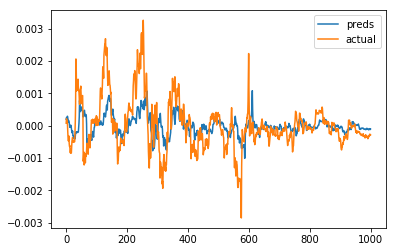

In [109]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

In [110]:
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'mva_tp_48_diff',
                             'direction_volume',
                             'weekday',
                             'month',
                             'hour']].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     963.2
Date:                Mon, 02 Oct 2017   Prob (F-statistic):               0.00
Time:                        22:37:09   Log-Likelihood:             1.8085e+05
No. Observations:               31424   AIC:                        -3.617e+05
Df Residuals:                   31417   BIC:                        -3.616e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.087e-05   1.33e-05      1.564      0.118   -5.29e-06     4.7e-05
x1            11.0424      0.162     68.354      0.000      10.726      11.359
x2            -4.9631      0.254    -19.547      0.000      -5.461      -4.465
x3          4.976e-07   6.24e-08      7.970      0.000    3.75e-07     6.2e-07
x4         -4.279e-06   2.16e-06     -1.978      0.048   -8.52e-06   -3.84e-08
x5         -2.489e-06    1.3e-06     -1.918      0.055   -5.03e-06     5.4e-08
x6         -2.377e-08   6.24e-07     -0.038      0.970   -1.25e-06     1.2e-06
==============================================================================
Omnibus:                    17632.464   Durbin-Watson:                   0.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12508055.806
Skew:                          -1.304   Prob(JB):                         0.00
Kurtosis:                     100.705   Cond. No.                     4.48e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.48e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [111]:
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'mva_tp_48_diff',
                             'direction_volume',
                             'weekday',
                             'month']].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     1156.
Date:                Mon, 02 Oct 2017   Prob (F-statistic):               0.00
Time:                        22:37:45   Log-Likelihood:             1.8085e+05
No. Observations:               31424   AIC:                        -3.617e+05
Df Residuals:                   31418   BIC:                        -3.616e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.059e-05   1.12e-05      1.832      0.067   -1.44e-06    4.26e-05
x1            11.0424      0.162     68.355      0.000      10.726      11.359
x2            -4.9631      0.254    -19.547      0.000      -5.461      -4.465
x3          4.976e-07   6.24e-08      7.970      0.000    3.75e-07     6.2e-07
x4         -4.279e-06   2.16e-06     -1.978      0.048   -8.52e-06   -3.84e-08
x5         -2.488e-06    1.3e-06     -1.918      0.055   -5.03e-06    5.39e-08
==============================================================================
Omnibus:                    17632.776   Durbin-Watson:                   0.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12508022.574
Skew:                          -1.304   Prob(JB):                         0.00
Kurtosis:                     100.705   Cond. No.                     4.48e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.48e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [112]:
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'mva_tp_48_diff',
                             'direction_volume',
                             'weekday']].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     1444.
Date:                Mon, 02 Oct 2017   Prob (F-statistic):               0.00
Time:                        22:38:34   Log-Likelihood:             1.8085e+05
No. Observations:               31424   AIC:                        -3.617e+05
Df Residuals:                   31419   BIC:                        -3.616e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.057e-06    7.8e-06      0.649      0.517   -1.02e-05    2.03e-05
x1            11.0424      0.162     68.352      0.000      10.726      11.359
x2            -4.9555      0.254    -19.519      0.000      -5.453      -4.458
x3          4.958e-07   6.24e-08      7.943      0.000    3.73e-07    6.18e-07
x4         -4.263e-06   2.16e-06     -1.970      0.049    -8.5e-06   -2.25e-08
==============================================================================
Omnibus:                    17490.774   Durbin-Watson:                   0.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12512809.001
Skew:                          -1.279   Prob(JB):                         0.00
Kurtosis:                     100.725   Cond. No.                     4.48e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.48e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [191]:
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'mva_tp_48_diff',
                             'direction_volume']].iloc[24 - hist:-hist].values)
y = rs_clip['24h_price_diff'].iloc[24:].values
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     1924.
Date:                Tue, 03 Oct 2017   Prob (F-statistic):               0.00
Time:                        00:17:52   Log-Likelihood:             1.8085e+05
No. Observations:               31424   AIC:                        -3.617e+05
Df Residuals:                   31420   BIC:                        -3.617e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.723e-06   4.33e-06     -1.784      0.074   -1.62e-05    7.62e-07
x1            11.0326      0.161     68.321      0.000      10.716      11.349
x2            -4.9314      0.254    -19.445      0.000      -5.428      -4.434
x3          4.949e-07   6.24e-08      7.928      0.000    3.73e-07    6.17e-07
==============================================================================
Omnibus:                    17530.692   Durbin-Watson:                   0.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12518673.329
Skew:                          -1.285   Prob(JB):                         0.00
Kurtosis:                     100.747   Cond. No.                     4.47e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

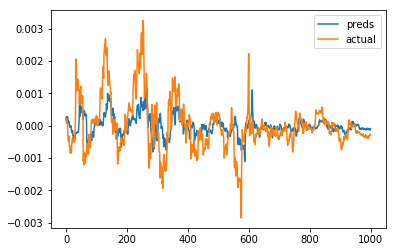

In [192]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

In [193]:
# make sure sklearn gives us the same thing
from sklearn.linear_model import LinearRegression as lr

In [194]:
reg = lr()
X = rs_clip[['mva_tp_24_diff',
             'mva_tp_48_diff',
             'direction_volume']].iloc[24 - hist:-hist][:-1000]
y = rs_clip['24h_price_diff'].iloc[24:][:-1000]
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [195]:
reg.score(X, y)

0.15517238174474945

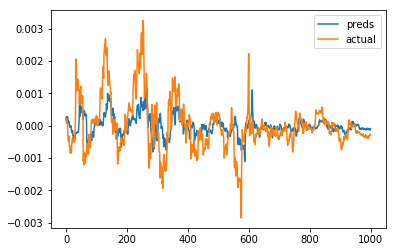

In [199]:
preds2 = reg.predict(rs_clip[['mva_tp_24_diff',
                             'mva_tp_48_diff',
                             'direction_volume']].iloc[24 - hist:-hist][-1000:])
plt.plot(preds2, label='preds')
plt.plot(rs_clip['24h_price_diff'].iloc[24:][-1000:].values, label='actual')
l = plt.legend()

In [200]:
np.allclose(preds2, preds)

True

In [201]:
fit.conf_int()

array([[ -1.62090797e-05,   7.62085816e-07],
       [  1.07161378e+01,   1.13491621e+01],
       [ -5.42845499e+00,  -4.43430928e+00],
       [  3.72576541e-07,   6.17291045e-07]])

# does it work a little better on more recent data?

In [132]:
rs_clip.shape

(32448, 17)

In [133]:
cut = 20000
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'mva_tp_48_diff',
                             'direction_volume']].iloc[24 - hist:-hist].values[cut:])
y = rs_clip['24h_price_diff'].iloc[24:].values[cut:]
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     1285.
Date:                Mon, 02 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:03:14   Log-Likelihood:                 70484.
No. Observations:               11424   AIC:                        -1.410e+05
Df Residuals:                   11420   BIC:                        -1.409e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.244e-06   4.75e-06      1.734      0.083   -1.07e-06    1.76e-05
x1            12.0365      0.270     44.656      0.000      11.508      12.565
x2            -0.8018      0.390     -2.059      0.040      -1.565      -0.038
x3           4.27e-07   4.17e-08     10.251      0.000    3.45e-07    5.09e-07
==============================================================================
Omnibus:                     5158.575   Durbin-Watson:                   0.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           288058.151
Skew:                           1.382   Prob(JB):                         0.00
Kurtosis:                      27.444   Cond. No.                     1.07e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

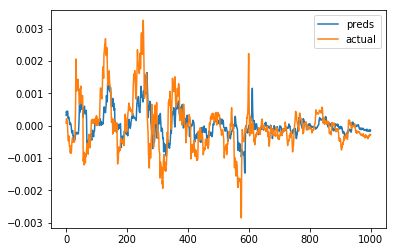

In [134]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

In [135]:
cut = 20000
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'direction_volume']].iloc[24 - hist:-hist].values[cut:])
y = rs_clip['24h_price_diff'].iloc[24:].values[cut:]
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     1925.
Date:                Mon, 02 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:04:22   Log-Likelihood:                 70482.
No. Observations:               11424   AIC:                        -1.410e+05
Df Residuals:                   11421   BIC:                        -1.409e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.156e-06   4.75e-06      1.716      0.086   -1.16e-06    1.75e-05
x1            11.6549      0.196     59.556      0.000      11.271      12.039
x2          4.289e-07   4.17e-08     10.296      0.000    3.47e-07    5.11e-07
==============================================================================
Omnibus:                     5163.025   Durbin-Watson:                   0.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           291999.867
Skew:                           1.381   Prob(JB):                         0.00
Kurtosis:                      27.613   Cond. No.                     4.75e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.75e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

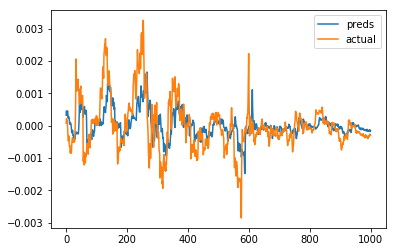

In [136]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

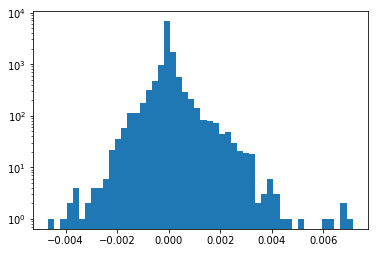

In [139]:
f = plt.hist(y, bins=50)
s = plt.yscale('log')

In [146]:
cut = 5000
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'direction_volume']].iloc[24 - hist:-hist].values[cut:])
y = rs_clip['24h_price_diff'].iloc[24:].values[cut:]
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     4627.
Date:                Mon, 02 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:08:19   Log-Likelihood:             1.6056e+05
No. Observations:               26424   AIC:                        -3.211e+05
Df Residuals:                   26421   BIC:                        -3.211e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.992e-06   3.42e-06      0.874      0.382   -3.72e-06     9.7e-06
x1            12.0789      0.127     94.806      0.000      11.829      12.329
x2          4.289e-07   4.54e-08      9.458      0.000     3.4e-07    5.18e-07
==============================================================================
Omnibus:                    30361.267   Durbin-Watson:                   0.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24858521.065
Skew:                          -5.241   Prob(JB):                         0.00
Kurtosis:                     152.894   Cond. No.                     2.82e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.82e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [147]:
def reject_outliers(sr, iq_range=0.5):
    # gets the iqr within the iq_range, and drops anything outside 1.5iqr of the 1st and 3rd quartiles
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    low_cut = qlow - 1.5 * iqr
    hi_cut = qhigh + 1.5 * iqr
    return sr[(sr < hi_cut) & (sr > low_cut)]

In [156]:
# get non-outliers in ydata for fit
non_out_price_diff = reject_outliers(rs_clip['24h_price_diff'])
idx = non_out_price_diff.index

In [157]:
non_out_price_diff.shape

(26372,)

In [158]:
rs_clip['24h_price_diff'].iloc[24:].shape

(32424,)

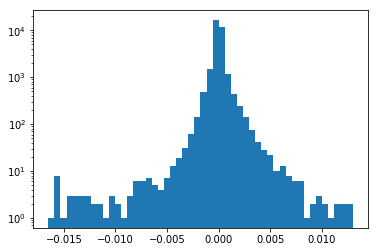

In [159]:
f = plt.hist(rs_clip['24h_price_diff'].iloc[24:], bins=50)
plt.yscale('log')

In [160]:
cut = 5000
hist = 12
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'direction_volume']].loc[idx].iloc[24 - hist:-hist].values[cut:])
y = rs_clip['24h_price_diff'].loc[idx].iloc[24:].values[cut:]
fit = sm.OLS(y[:-1000], X[:-1000]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     830.3
Date:                Mon, 02 Oct 2017   Prob (F-statistic):               0.00
Time:                        23:12:03   Log-Likelihood:             1.5318e+05
No. Observations:               20348   AIC:                        -3.064e+05
Df Residuals:                   20345   BIC:                        -3.063e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.348e-05   9.23e-07    -14.605      0.000   -1.53e-05   -1.17e-05
x1             6.5412      0.162     40.369      0.000       6.224       6.859
x2          1.782e-07    3.2e-08      5.564      0.000    1.15e-07    2.41e-07
==============================================================================
Omnibus:                      983.609   Durbin-Watson:                   0.363
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3652.037
Skew:                          -0.016   Prob(JB):                         0.00
Kurtosis:                       5.075   Cond. No.                     5.07e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

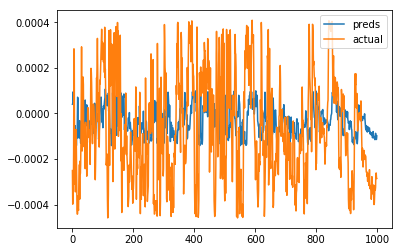

In [161]:
preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

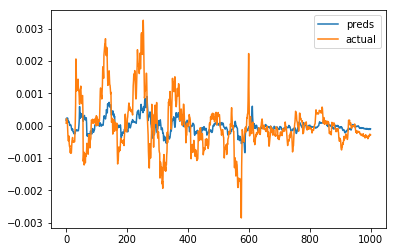

In [162]:
X = sm.add_constant(rs_clip[['mva_tp_24_diff',
                             'direction_volume']].iloc[24 - hist:-hist].values[cut:])
y = rs_clip['24h_price_diff'].iloc[24:].values[cut:]

preds = fit.predict(X[-1000:])
plt.plot(preds, label='preds')
plt.plot(y[-1000:], label='actual')
l = plt.legend()

# it seems cutting off the first few thousand points helps. Beyond that, you don't get too much.  Seems like removing outliers is not a good thing here, really reduces the r-squared

# load all the data, and see if it seems to follow the trend in general